In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.image as mpimg
from imgaug import augmenters as iaa

import random

## Define Helper Function

In [7]:
# combine folder with image name

def getName(filePath):
    myImagePathL = filePath.split('/')[-2:]
    myImagePath = os.path.join(myImagePathL[0],myImagePathL[1])
    return myImagePath

In [8]:
# setup the dataframe

def importDataInfo(path):
    columns = ['Filename','Steering']
    noOfFolders = len(os.listdir(path))//2
    data = pd.DataFrame()
    for x in range(0,4):
        if x != 0:
            pass
        else:
            dataNew = pd.read_csv(os.path.join(path, f'log_{x}.csv'), names = columns)
            print(f'{x}:{dataNew.shape[0]} ',end='')
            #### REMOVE FILE PATH AND GET ONLY FILE NAME
            #print(getName(data['center'][0]))
            dataNew['Filename']=dataNew['Filename'].apply(getName)
            data =data.append(dataNew,True )
    print(' ')
    print('Total Images Imported',data.shape[0])
    return data

In [9]:
# remove high occurence image

def balanceData(data,display=True):
    nBin = 31
    samplesPerBin = 300
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.title('Data Visualisation')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.title('Balanced Data')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    return data

In [10]:
# prepare data for split train test

def loadData(path, data):
    imagesPath = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        imagesPath.append( os.path.join(path,indexed_data[0]))
        steering.append(float(indexed_data[1]))
    imagesPath = np.asarray(imagesPath)
    steering = np.asarray(steering)
    return imagesPath, steering

In [11]:
# image augmentation

def augmentImage(imgPath,steering):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.5, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    return img, steering

In [12]:
# separate process for train and test data.

def dataGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = preProcess(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))

In [13]:
import matplotlib.pyplot as plt
def preProcess(img):
#     img = cv2.imread(filePath) 
    img = img[54:120,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    plt.imshow(img)
    return img

## Load Data

In [14]:
df = importDataInfo('DataCollected')

0:3305  
Total Images Imported 3305


In [15]:
df.head(5)

,Filename,Steering
0,IMG0\Image_1638858271625566.jpg,0.0
1,IMG0\Image_1638858272182506.jpg,0.0
2,IMG0\Image_1638858272613807.jpg,0.0
3,IMG0\Image_1638858273052654.jpg,0.0
4,IMG0\Image_1638858273483709.jpg,0.0


## Balance Data

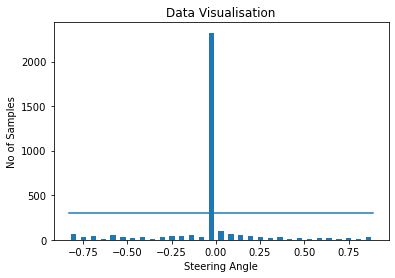

Removed Images: 2023
Remaining Images: 1282


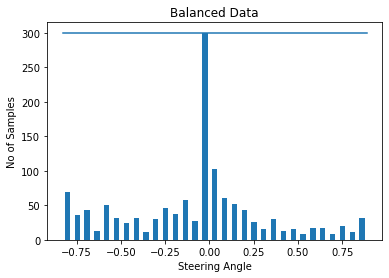

In [16]:
df_balanced = balanceData(df)

In [17]:
df_balanced

,Filename,Steering
1,IMG0\Image_1638858272182506.jpg,0.00
2,IMG0\Image_1638858272613807.jpg,0.00
9,IMG0\Image_1638858275655949.jpg,0.00
10,IMG0\Image_1638858276089205.jpg,0.26
12,IMG0\Image_1638858276955066.jpg,0.21
...,...,...
3281,IMG0\Image_1638858476885574.jpg,0.00
3283,IMG0\Image_163885847694729.jpg,0.00
3288,IMG0\Image_163885847710798.jpg,0.00
3303,IMG0\Image_1638858477622406.jpg,0.00


# Optional Code

In [18]:
#try to categorize into 3 class
df_balanced.loc[df_balanced['Steering'] > 0, 'C_Steering'] = 0.25
df_balanced.loc[df_balanced['Steering'] < 0, 'C_Steering'] = -0.25
df_balanced.loc[df_balanced['Steering'] == 0, 'C_Steering'] = 0

In [19]:
#implementation of 3 class
X = df_balanced["Filename"]
y = df_balanced["C_Steering"]

In [ ]:
# check path

# import pathlib
# pathlib.Path().resolve()

In [ ]:
#check preProcess image result

# preProcess("C:\MLCourse\MLCourse\self_driving_raspberry\DataCollected\IMG0\Image_163877726896649.jpg")

## Train Test Split

In [18]:
imagePath, steering = loadData("C:\MLCourse\MLCourse\self_driving_raspberry\DataCollected", df_balanced)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imagePath, steering,test_size=0.2,random_state=101)

In [20]:
X_train

array(['C:\\MLCourse\\MLCourse\\self_driving_raspberry\\DataCollected\\IMG0\\Image_1638858343666732.jpg',
       'C:\\MLCourse\\MLCourse\\self_driving_raspberry\\DataCollected\\IMG0\\Image_1638858467643168.jpg',
       'C:\\MLCourse\\MLCourse\\self_driving_raspberry\\DataCollected\\IMG0\\Image_1638858378430155.jpg',
       ...,
       'C:\\MLCourse\\MLCourse\\self_driving_raspberry\\DataCollected\\IMG0\\Image_1638858337993331.jpg',
       'C:\\MLCourse\\MLCourse\\self_driving_raspberry\\DataCollected\\IMG0\\Image_1638858399273017.jpg',
       'C:\\MLCourse\\MLCourse\\self_driving_raspberry\\DataCollected\\IMG0\\Image_1638858426402031.jpg'],
      dtype='<U89')

In [21]:
y_train

array([-0.33, -0.68,  0.23, ..., -0.52, -0.  ,  0.05])

## Create Model

In [24]:
model = Sequential()

model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
model.add(Convolution2D(64, (3, 3), activation='elu'))
model.add(Convolution2D(64, (3, 3), activation='elu'))

model.add(Flatten())
model.add(Dense(100, activation = 'elu'))
model.add(Dense(50, activation = 'elu'))
model.add(Dense(10, activation = 'elu'))
model.add(Dense(1))

model.compile(Adam(lr=0.0001),loss='mse')

In [ ]:
history = model.fit(dataGen(X_train, y_train, 100, 1),
                                  steps_per_epoch=100,
                                  epochs=10,
                                  validation_data=dataGen(X_test, y_test, 50, 0),
                                  validation_steps=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 63s 625ms/step - loss: 0.1208 - val_loss: 0.0953
Epoch 2/10
100/100 [==============================] - 62s 616ms/step - loss: 0.1041 - val_loss: 0.0911
Epoch 3/10
100/100 [==============================] - 81s 814ms/step - loss: 0.0980 - val_loss: 0.0924
Epoch 4/10
100/100 [==============================] - 85s 845ms/step - loss: 0.0961 - val_loss: 0.0940
Epoch 5/10
100/100 [==============================] - 100s 998ms/step - loss: 0.0948 - val_loss: 0.0976
Epoch 6/10
100/100 [==============================] - 98s 982ms/step - loss: 0.0909


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  MemoryError: Unable to allocate 15.1 MiB for an array with shape (50, 66, 200, 3) and data type float64
Traceback (most recent call last):

  File "E:\Anaconda\envs\TF2.2\lib\site-packages\tensorflow_core\python\ops\script_ops.py", line 236, in __call__
    ret = func(*args)

  File "E:\Anaconda\envs\TF2.2\lib\site-packages\tensorflow_core\python\data\ops\dataset_ops.py", line 789, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\johan\AppData\Local\Temp\ipykernel_15460\2546521958.py", line 16, in dataGen
    yield (np.asarray(imgBatch),np.asarray(steeringBatch))

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 15.1 MiB for an array with shape (50, 66, 200, 3) and data type float64


	 [[{{node PyFunc}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  MemoryError: Unable to allocate 15.1 MiB for an array with shape (50, 66, 200, 3) and data type float64
Traceback (most recent call last):

  File "E:\Anaconda\envs\TF2.2\lib\site-packages\tensorflow_core\python\ops\script_ops.py", line 236, in __call__
    ret = func(*args)

  File "E:\Anaconda\envs\TF2.2\lib\site-packages\tensorflow_core\python\data\ops\dataset_ops.py", line 789, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\johan\AppData\Local\Temp\ipykernel_15460\2546521958.py", line 16, in dataGen
    yield (np.asarray(imgBatch),np.asarray(steeringBatch))

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 15.1 MiB for an array with shape (50, 66, 200, 3) and data type float64


	 [[{{node PyFunc}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_1537]

Function call stack:
distributed_function -> distributed_function


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [21]:
model.save('Trained_model_V2-1.h5')
print('Model Saved')

Model Saved


In [22]:
print("test")

test


In [5]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
